# Spam Classifier

In [1]:
#import modules
import numpy as np
import pandas as pd
import math
from collections import defaultdict
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

To build the classifier, a sample toy data is taken for quick implementation of spam classification.

In [2]:
# Sample data
col_names = ['label', 'message']
messages = pd.read_csv("train_data.csv", header=None, names=col_names)
messages.head()

,label,message
0,1,It is raining offers today.
1,0,It is raining outside.
2,1,Check out my latest video!
3,0,Make sure you have checked all the important d...
4,0,There are no free lunches.


We can visualize different words in our data based on the frequency of their occurrence.

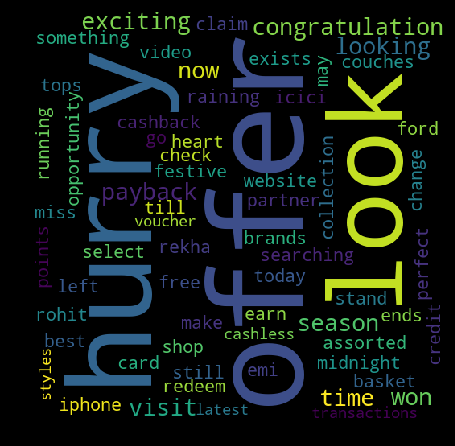

In [3]:
spam_words = ' '.join(list(messages[messages['label']==1]['message']))
spam_words = spam_words.lower()
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize = (8,6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Preprocessing for text data can help improve the accuracy and model's capacity to deal with data. Hence, next follows the commonly used text data preprocessing steps:<br><br>
1) Making all letter <b>lowercase</b> so that "OFFER" is same as "offer".<br><br>
2) <b>Tokenization</b>: Process of splitting message into pieces and throwing out all the punctuation. Eg, "Hi, Shall we meet tomorrow at 5?" to "Hi shall we meet tomorrow at 5"<br><br>
3) <b>Stemming</b>: Process of identifying a single word for all the derivative forms. Eg, for words - 'shared', 'sharing', saving a single word 'shar'. Porter Stemmer is the most commonly used.<br><br>
4) <b>Removing stop words</b>: Words such as 'a', 'at', 'the', 'is', 'an' do not hold much information and thus would be useful to drop for the classification process.<br><br>
5) <b>n-gram model</b>: Sometimes, context holds much more information than a single word. For instance, 'not good' may change the meaning entirely from treating 'not' and 'good' separately. Therefore, the choice of number of tokens to be treated together can be decided and accordingly an n-gram model can be trained.<br>

In [4]:
training_examples = len(messages.index)
categories = ['0', '1']
words = defaultdict(dict)
words_message_count = defaultdict(dict)
message_categories = defaultdict(dict)
unique_words = set()
tfidf = True

In [5]:
def process_message(message, lower_case=True, stem=True, stop_words=True, gram=1):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words)-gram+1):
            w += ' '.join(words[i:i+gram])
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
    return words

Two approaches to use the data:<br><br>
1) <b>Bag of words</b>: Count the 'term frequency' of each word in the dataset. <br>
$$ P(w) = \frac{\text{Total occurrences of w in dataset}}{\text{Total words in dataset}} $$
<br><br>
$$ P(w|spam) = \frac{\text{Total occurrences of w in spam messages}}{\text{Total words in spam messages}} $$
<br>
2) <b>TF-IDF (Term Frequency - Inverse Document Frequency)</b>: TF remains the same as defined above. IDF is as defined below:<br><br>
$$ IDF(w) = log \frac{\text{Total number of messages}}{\text{Total number of messages containing w}} $$
<br><br>
While term frequency helps shoot up the importance of a term, a very widely used term may become less informative and thus is accounted for by IDF. It helps give more weight to words that occur less frequently but convey more information.<br>

Therefore, with the new TF-IDF score defined for each word, the probabilities with Laplace smoothing are computed as follows:<br>

$$ P(w) = \frac{TF(w)*IDF(w)}{\sum_{\text{$\forall$ words x $\in$ dataset}}TF(x)*IDF(x)} $$
<br><br>
$$ P(w|spam) = \frac{TF(w|spam)*IDF(w) + \alpha}{\sum_{\text{$\forall$ words x $\in$ dataset}}TF(x|spam)*IDF(x) + \alpha * \sum_{\text{$\forall$ words x $\in$ dataset}}1} $$
<br><br>
<b>Laplace Smoothing</b>: This is to account for those words that are not seen in the training data even once. For $\alpha > 0$, the probability of a message being spam for a word seen for the first time in the test set does not drop to 0.

In [6]:
def train_data(fileName):
    global message_categories
    try:
        col_names = ['label', 'message']
        messages = pd.read_csv("train_data.csv", header=None, names=col_names, encoding="utf-8")
    except OSError as err:
        print("OS error: {0}".format(err))
    else:
        total_messages = len(messages.index)
        mul = total_messages//10
        message_categories = create_categories(categories)
        for idx, message in messages.iterrows():
            train(message)
            if (idx+1)%mul == 0:
                print ("Training done for {}/{} examples".format(idx+1, total_messages))

        print("Done!")
    
def create_categories(categories):
    message_categories = {str(category): {'total': 0, 'word_count': 0} 
                  for category in categories}
    return message_categories

message_categories = create_categories(categories)

tfidf = True
def train(message):
    global unique_words
    category = str(message['label'])

    # Process message and get a list of useful tokens
    words_list = process_message(message['message'])

    # Find the unique words in the list of words and combine it with unique_words set
    unique_words = set(list(unique_words) + words_list)
    
    # for a given word, update the count of category in which it is seen
    for word in words_list:
        if words[word].get(category):
            words[word][category] += 1
        else:
            words[word][category] = 1
        
    # Update the count of the times this category message has been seen
    message_categories[category]['total'] += 1

    # Update the count of words seen for a particular category
    message_categories[category]['word_count'] += len(message)

    if tfidf:
        # Find inverse document frequency for each word
        unique_message_words = set(words_list)
        for word in unique_message_words:
            
            if words_message_count[word].get(category):
                words_message_count[word][category] += 1
            else:
                words_message_count[word][category] = 1
            
            if words_message_count[word].get('total_count'):
                words_message_count[word]['total_count'] += 1
            else:
                words_message_count[word]['total_count'] = 1

def get_category_log_prob(category, count):
    prob = float(count)/(training_examples + len(message_categories.keys()))
    return math.log(prob)

def get_predictors_log_idf(category, words_list):
    log_prob = 0.0
    for word in words_list:
        smoothed_frequency = training_examples
        if words_message_count.get(word) and words_message_count[word].get(category):
            smoothed_frequency = words_message_count[word]['total_count']
        idf = math.log(training_examples/smoothed_frequency)
        log_prob += idf
        
    if log_prob == 0:
        return 0.0
    return math.log(log_prob)

def get_predictors_log_likelihood(category, words_list):
    word_count = message_categories[category]['word_count'] + len(unique_words)
    log_likelihood = 0
    for word in words_list:
        smoothed_frequency = 1
        if (words.get(word) and words[word].get(category)):
            smoothed_frequency += words[word][category]
        log_likelihood += math.log(smoothed_frequency/float(word_count))
    return log_likelihood

To compute $P(spam|words)$, we use the naive Bayes classifier:<br><br>
$$P(spam|words) = \frac{P(words|spam) * P(spam)}{P(words)}$$

<br>
With the independence assumption of naive Bayes classifier, we can compute it as follows:
$$P(spam|words) = \frac{P(word_1|spam) * P(spam)}{P(word_1)} * \frac{P(word_2|spam) * P(spam)}{P(word_2)} * ... * \frac{P(word_n|spam) * P(spam)}{P(word_n)}$$

where n is the number of words in the message to be classified as spam or not.

In [7]:
def classify(message):
    global message_categories
    scores = {}
    best_fit = {}
    best_score = float("-inf")
    sum_scores = 0.0
    words_list = process_message(message)
    for category, category_data in message_categories.items():
        prior_log_prob = get_category_log_prob(category, category_data['total'])
        
        term_frequency_log_prob = get_predictors_log_likelihood(category, words_list)
        inv_doc_frequency_log_prob = 0
        if tfidf:
            inv_doc_frequency_log_prob = get_predictors_log_idf(category, words_list)
        predictors_log_likelihood = term_frequency_log_prob + inv_doc_frequency_log_prob

        score = math.exp(prior_log_prob + predictors_log_likelihood)
        scores[category] = score
        sum_scores += score
        if score > best_score:
            best_fit["category"] = category
            best_fit["score"] = score
            best_score = score

    for score_key in scores.keys():
        scores[score_key] /= sum_scores
    best_fit['score'] = scores[best_fit['category']]
    return (best_fit, scores)
    

In [8]:
#print ("Categories: {0}".format(categories))
train_data("train_data.csv")

Training done for 4/42 examples
Training done for 8/42 examples
Training done for 12/42 examples
Training done for 16/42 examples
Training done for 20/42 examples
Training done for 24/42 examples
Training done for 28/42 examples
Training done for 32/42 examples
Training done for 36/42 examples
Training done for 40/42 examples
Done!


In [9]:
classify("The offer is out there!")

({'category': '1', 'score': 0.7364975450081832},
 {'0': 0.2635024549918168, '1': 0.7364975450081832})

In [10]:
classify("I got late yesterday, will reach office by 11")

({'category': '0', 'score': 0.9753655022384906},
 {'0': 0.9753655022384906, '1': 0.024634497761509427})

In [11]:
classify("Congratulations, you're awarded $500")

({'category': '1', 'score': 0.9015716458003772},
 {'0': 0.09842835419962284, '1': 0.9015716458003772})

In [12]:
classify("It generally rains this time of the year.")

({'category': '0', 'score': 0.5707294279299078},
 {'0': 0.5707294279299078, '1': 0.4292705720700922})

In [13]:
classify("Don't waste any more time, the perfect package is here for you!")

({'category': '1', 'score': 0.8117719022808056},
 {'0': 0.1882280977191943, '1': 0.8117719022808056})

The model looks like working now but due to lesser training examples, the prediction quality is not that good. Now putting the code in script, lets try to run for same input and classification examples!

In [14]:
from naive_bayes import NaiveBayes

In [15]:
categories = ["0", "1"]
nb = NaiveBayes(categories, "train_data.csv")

Total examples: 42
Training set size: 29
Test set size: 13


In [16]:
nb.train_data()

Training done for 2/29 examples
Training done for 4/29 examples
Training done for 6/29 examples
Training done for 8/29 examples
Training done for 10/29 examples
Training done for 12/29 examples
Training done for 14/29 examples
Training done for 16/29 examples
Training done for 18/29 examples
Training done for 20/29 examples
Training done for 22/29 examples
Training done for 24/29 examples
Training done for 26/29 examples
Training done for 28/29 examples
Done!


In [17]:
nb.classify("The offer is out there!")

({'category': '1', 'score': 0.6550029486927461},
 {'0': 0.3449970513072538, '1': 0.6550029486927461})

In [18]:
nb.classify("Don't waste any more time, the perfect package is here for you!")

({'category': '1', 'score': 0.8472725810973587},
 {'0': 0.1527274189026413, '1': 0.8472725810973587})

In [19]:
nb.classify("I got late yesterday, will reach office by 11")

({'category': '0', 'score': 0.9725838041655612},
 {'0': 0.9725838041655612, '1': 0.02741619583443876})

In [20]:
nb.classify("It generally rains this time of the year.")

({'category': '0', 'score': 0.8453789134201236},
 {'0': 0.8453789134201236, '1': 0.15462108657987644})

In [21]:
nb.classify("Congratulations, you're awarded $500")

({'category': '1', 'score': 0.8705761481625208},
 {'0': 0.12942385183747906, '1': 0.8705761481625208})

In [22]:
nb.classify("I waited for a long time")

({'category': '0', 'score': 0.8475815011962574},
 {'0': 0.8475815011962574, '1': 0.1524184988037426})

In [23]:
nb.classify("Want a free trip to Paris?")

({'category': '0', 'score': 0.5002986595224441},
 {'0': 0.5002986595224441, '1': 0.4997013404775559})

In [24]:
test_results = nb.test()
print(test_results['accuracy'])
#print(test_results['confusion_matrix'])

0.615384615385


The model above shows an accuracy of about 76% for the toy dataset. Now, we can try a bigger dataset to see real-time performance of the model.

In [25]:
filePath = "smsspamcollection/SMSSpamCollection"
col_names = ['category', 'message']
messages = pd.read_csv(filePath, header=None, names=col_names, sep="\t")
messages.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


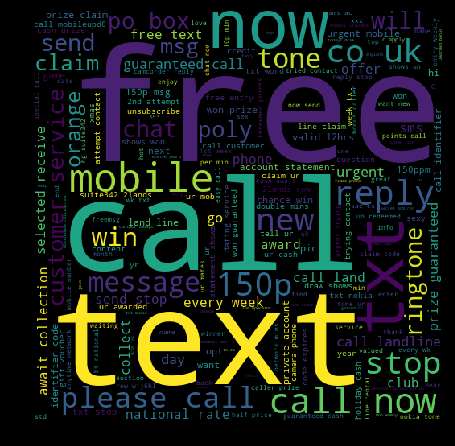

In [26]:
spam_words = ' '.join(list(messages[messages['category']=='spam']['message']))
spam_words = spam_words.lower()
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize = (8,6), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [27]:
import csv
fname = "smsspamcollection/SMSSpamCollection"
with open(fname) as f:
    content = f.readlines()

with open('testfile.csv', "w") as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for line in content:
        words = line.split()
        elems = [words[0], ' '.join(words[1:])]
        writer.writerow([elems[0], elems[1]])
    csv_file.close()

In [28]:
from naive_bayes import NaiveBayes
categories = ["ham", "spam"]
nb1 = NaiveBayes(categories, "testfile.csv")
nb1.train_data()
test_results = nb1.test()
print("Accuracy: "+str(test_results['accuracy']))
#print(test_results['confusion_matrix'])

Total examples: 5574
Training set size: 3901
Test set size: 1673
Training done for 390/3901 examples
Training done for 780/3901 examples
Training done for 1170/3901 examples
Training done for 1560/3901 examples
Training done for 1950/3901 examples
Training done for 2340/3901 examples
Training done for 2730/3901 examples
Training done for 3120/3901 examples
Training done for 3510/3901 examples
Training done for 3900/3901 examples
Done!
Accuracy: 0.979677226539


The model performs decent on the data set of texts and classifies with an accuracy of 98%